<a href="https://colab.research.google.com/github/jhon-aparicio/DataSet/blob/main/PersonaUNetS2.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
import skimage.draw
import random


In [2]:
!git clone https://github.com/johnpaipa/semanticSegmentation.git

Cloning into 'semanticSegmentation'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 126 (delta 0), reused 1 (delta 0), pack-reused 123
Receiving objects: 100% (126/126), 73.51 MiB | 17.55 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [3]:
cd semanticSegmentation/


/content/semanticSegmentation


In [4]:
!python setup.py install

/usr/local/lib/python3.9/dist-packages/setuptools/dist.py:697: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/setuptools/dist.py:697: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/setuptools/dist.py:697: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  warnings.warn(
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'


In [5]:
ROOT_DIR = '/content/semanticSegmentation'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist'

sys.path.append(ROOT_DIR) 

from mrcnn import visualize
from mrcnn.config import Config
from mrcnn import model as modellib, utils

In [6]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


In [7]:
class CascoConfig(Config):
    """Configuration for training on the helmet  dataset.
    """
    # Give the configuration a recognizable name
    NAME = "persona"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 (casco)

    # All of our training images are 512x512
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 500

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = CascoConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [8]:

class CascoDataset(utils.Dataset):

    def load_cascos(self, dataset_dir, subset):
        """Load a subset of the Casco dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("persona", 1, "persona")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "persona",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a casco dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "persona":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "persona":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [9]:
dataset_train = CascoDataset()
dataset_train.load_cascos("/content/semanticSegmentation/dataset/persona", "train")
dataset_train.prepare()

# Validation dataset
dataset_val = CascoDataset()
dataset_val.load_cascos("/content/semanticSegmentation/dataset/persona", "val")
dataset_val.prepare()

In [10]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [11]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

<ipython-input-8-4d23ee05384c>:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)


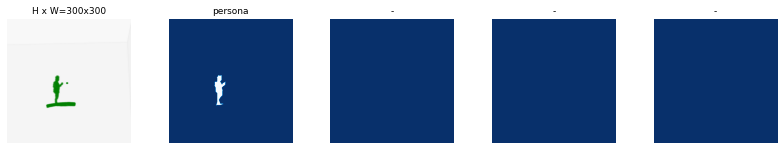

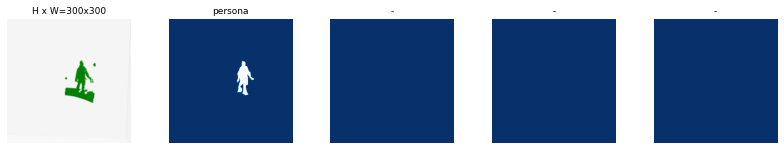

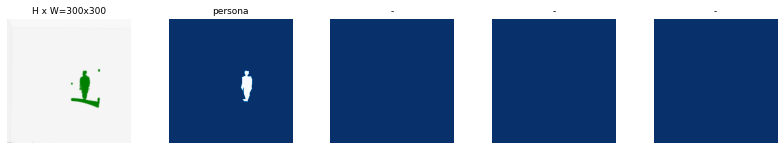

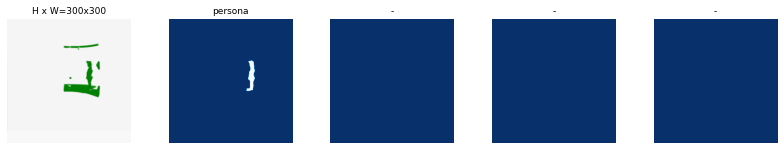

In [12]:
# Load and display random samples
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)
    

<ipython-input-8-4d23ee05384c>:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)


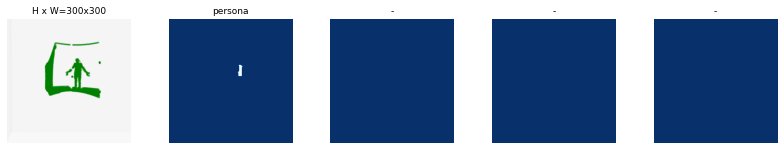

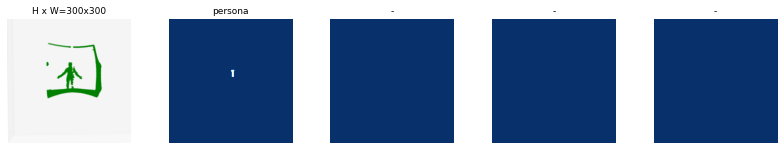

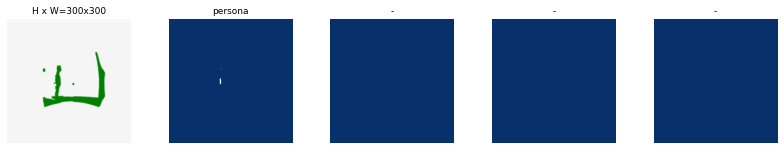

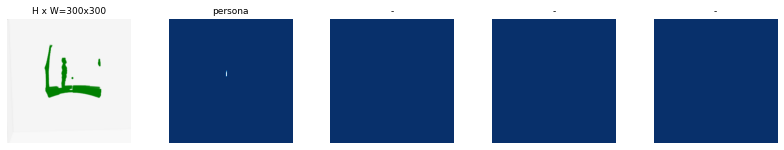

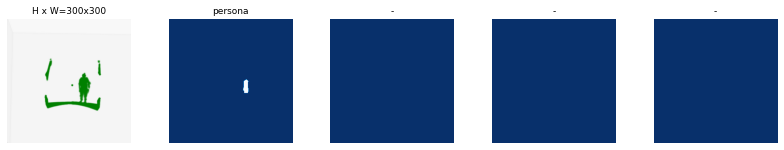

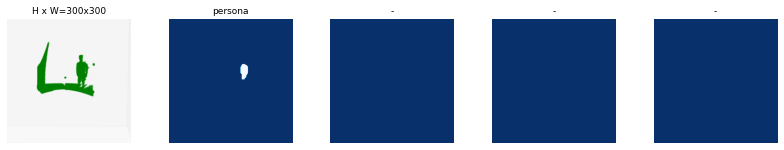

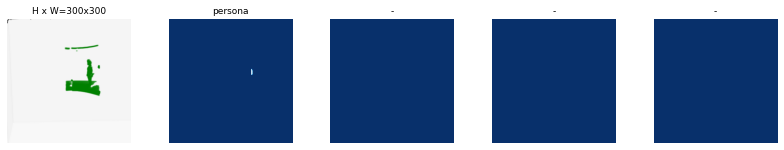

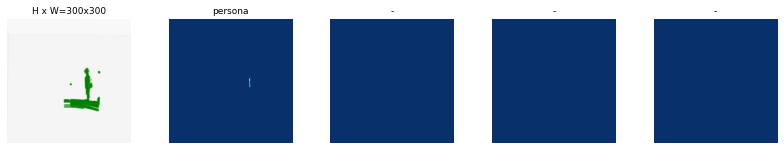

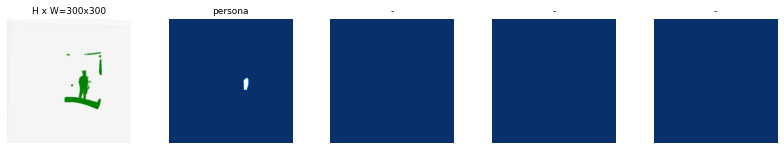

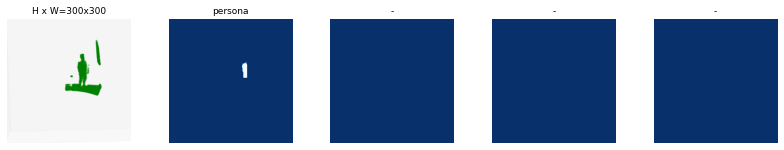

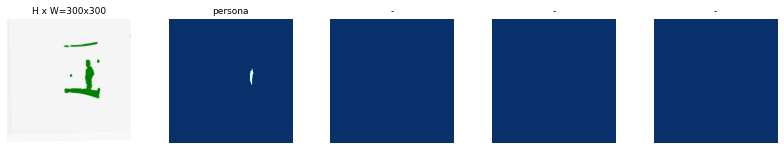

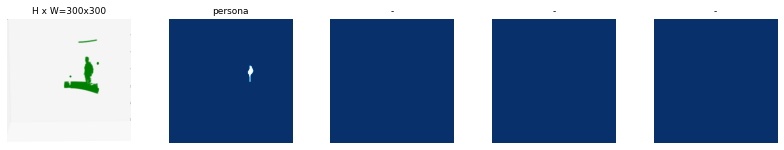

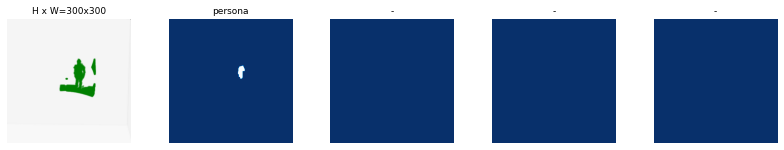

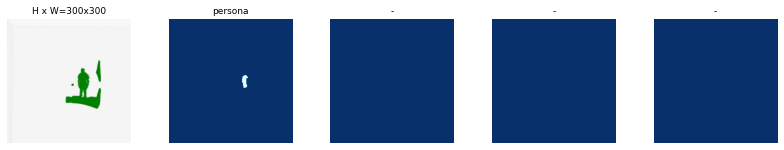

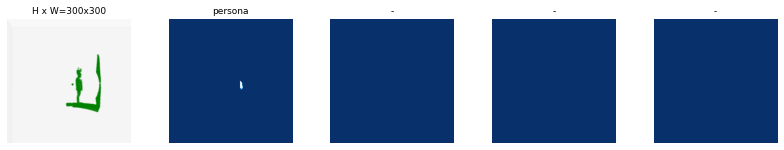

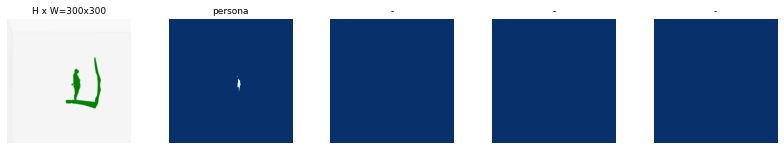

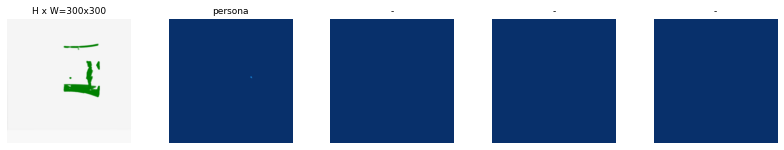

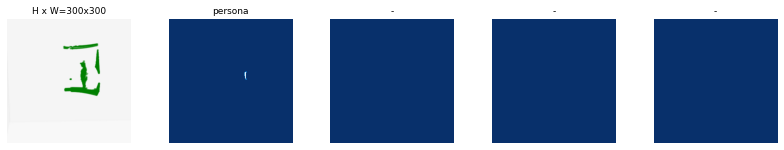

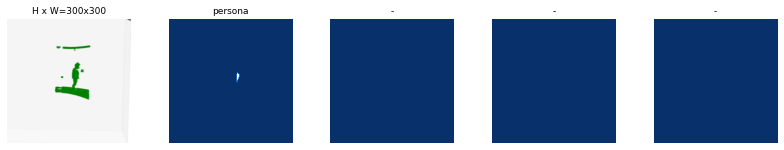

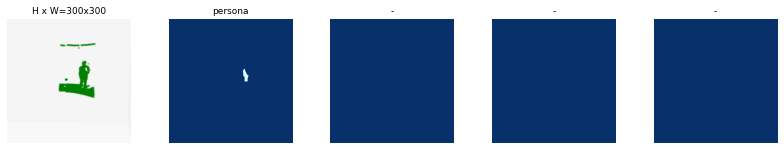

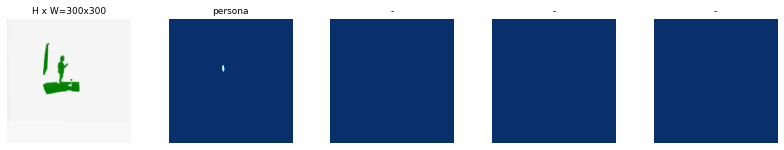

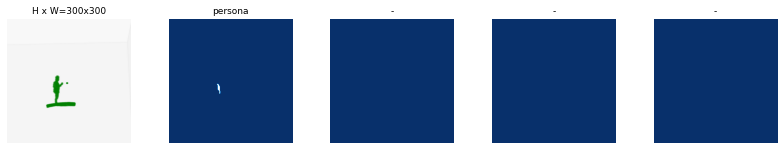

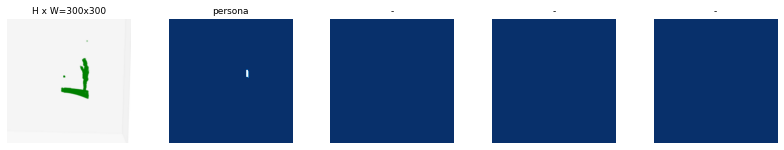

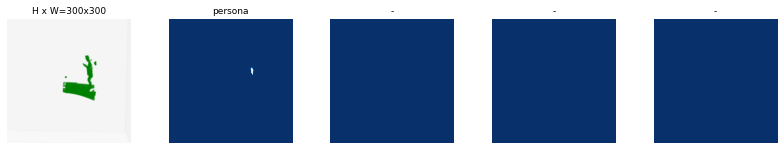

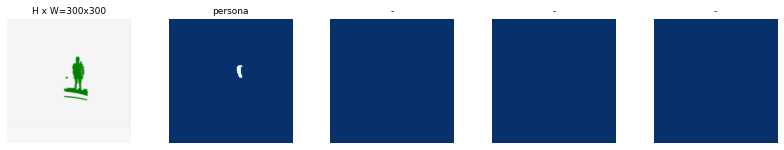

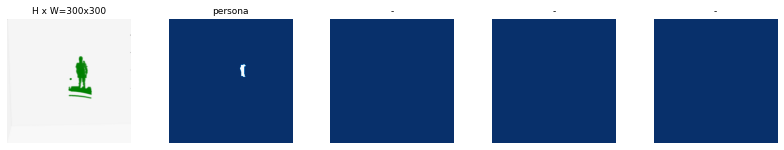

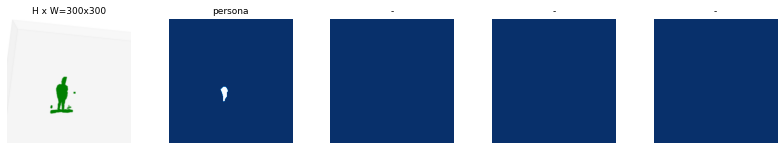

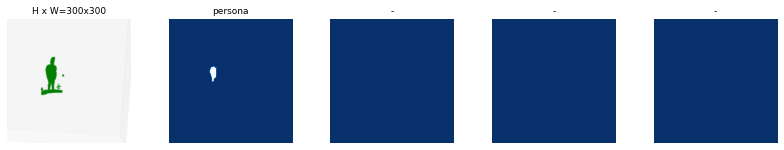

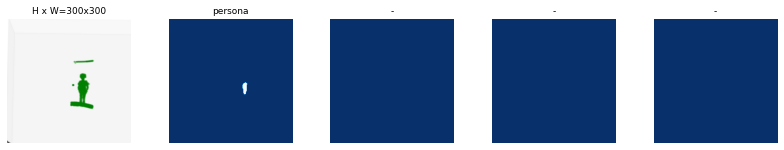

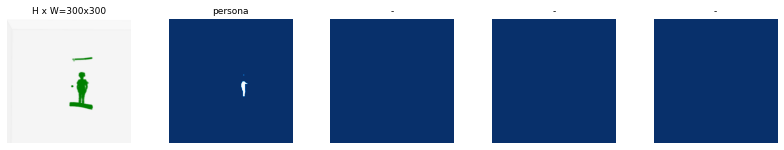

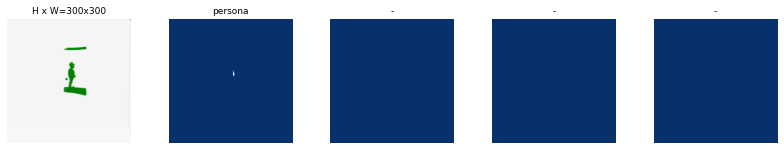

<ipython-input-13-4e675a0c8f8c>:9: UserWarning: /content/semanticSegmentation/dataset/persona/segmentadas/Hat_Front90_1.png is a low contrast image
  skimage.io.imsave(f'/content/semanticSegmentation/dataset/persona/segmentadas/{image_name}', mask_smooth[:, :, 0])


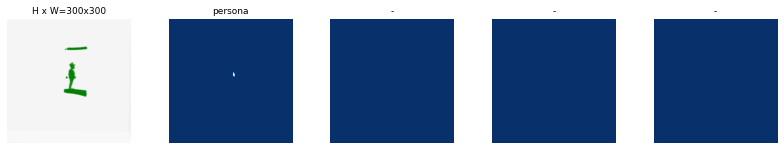

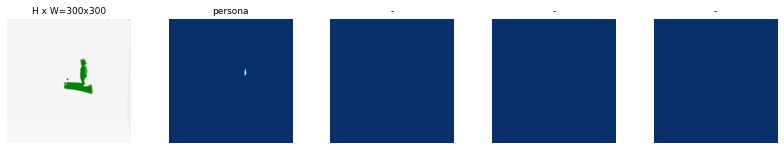

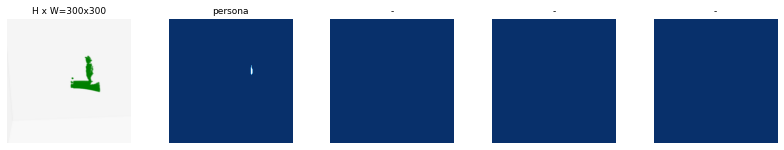

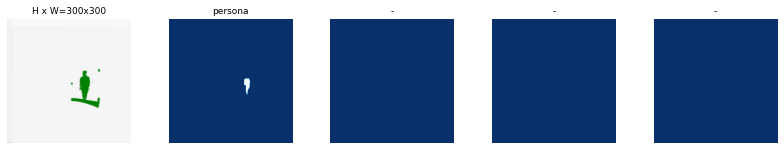

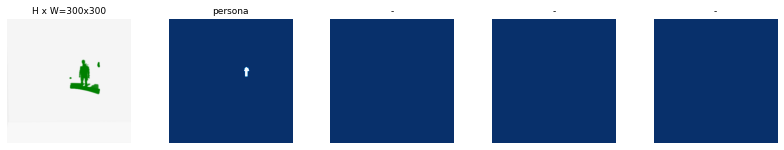

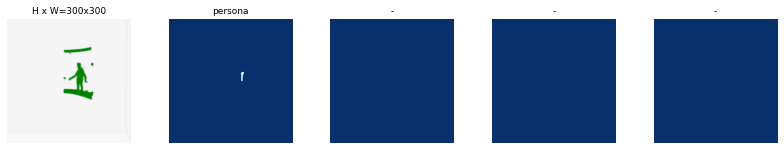

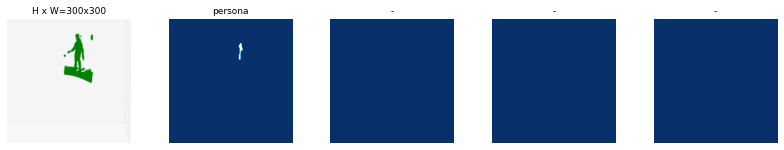

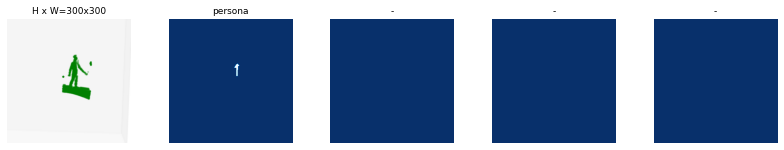

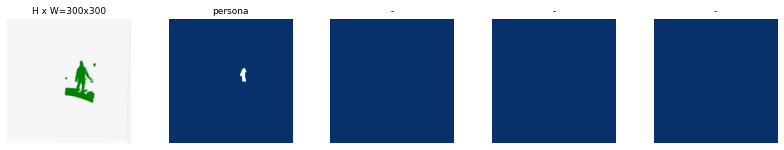

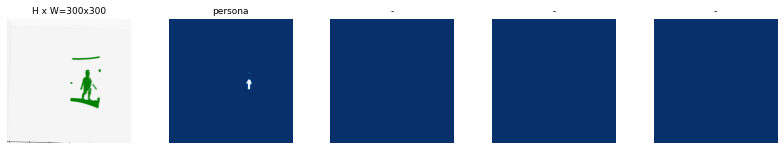

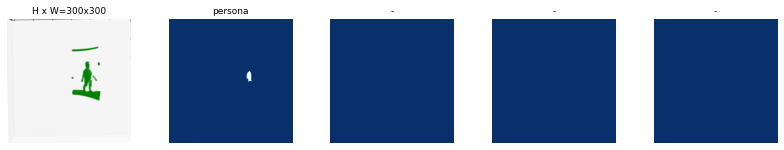

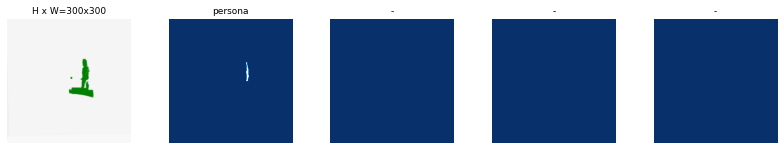

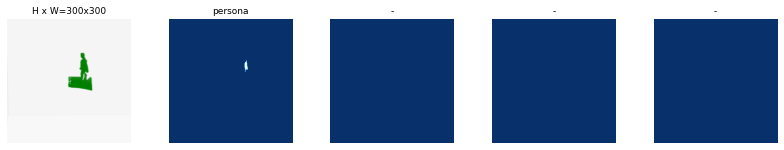

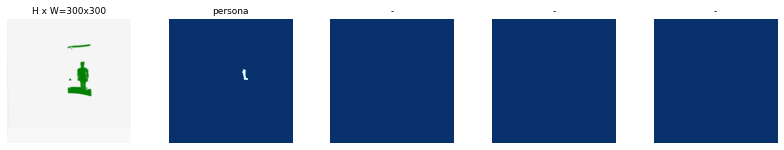

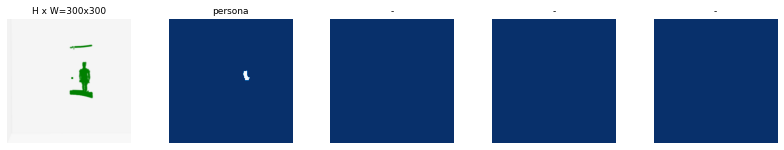

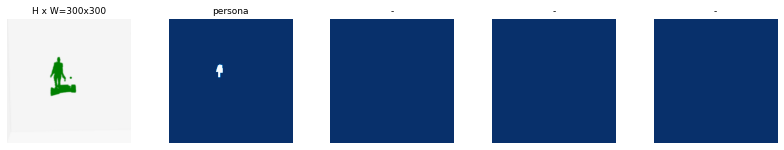

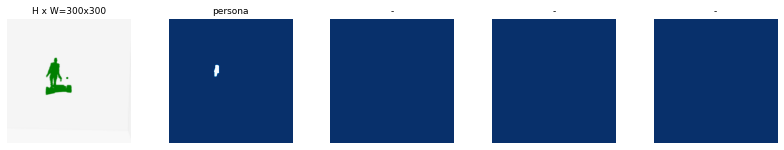

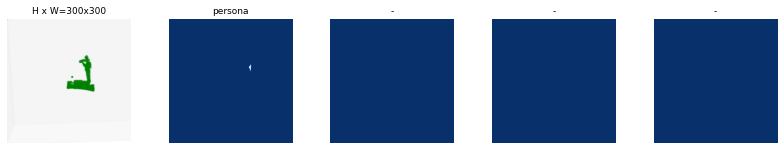

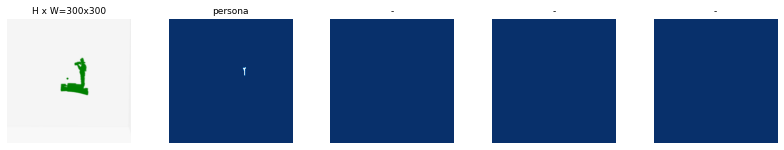

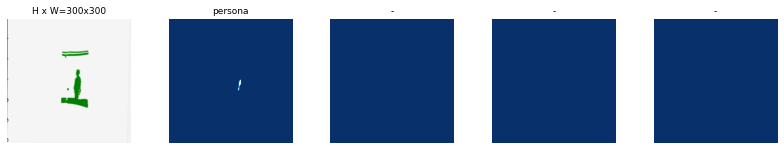

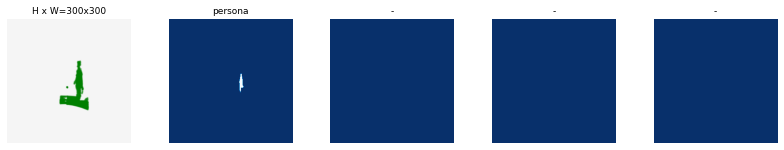

In [13]:
from skimage.filters import gaussian
image_idSeg = dataset.image_ids
for image_id in image_idSeg:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    mask_smooth = gaussian(mask, sigma=1.2)
    visualize.display_top_masks(image, mask_smooth, class_ids, dataset.class_names)
    image_name = dataset.image_info[image_id]['id']
    skimage.io.imsave(f'/content/semanticSegmentation/dataset/persona/segmentadas/{image_name}', mask_smooth[:, :, 0])

<ipython-input-8-4d23ee05384c>:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)


image_id  29 /content/semanticSegmentation/dataset/persona/train/Hat_Front_2.png
image                    shape: (300, 300, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (300, 300, 1)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:  127.00000  max:  209.00000  int32


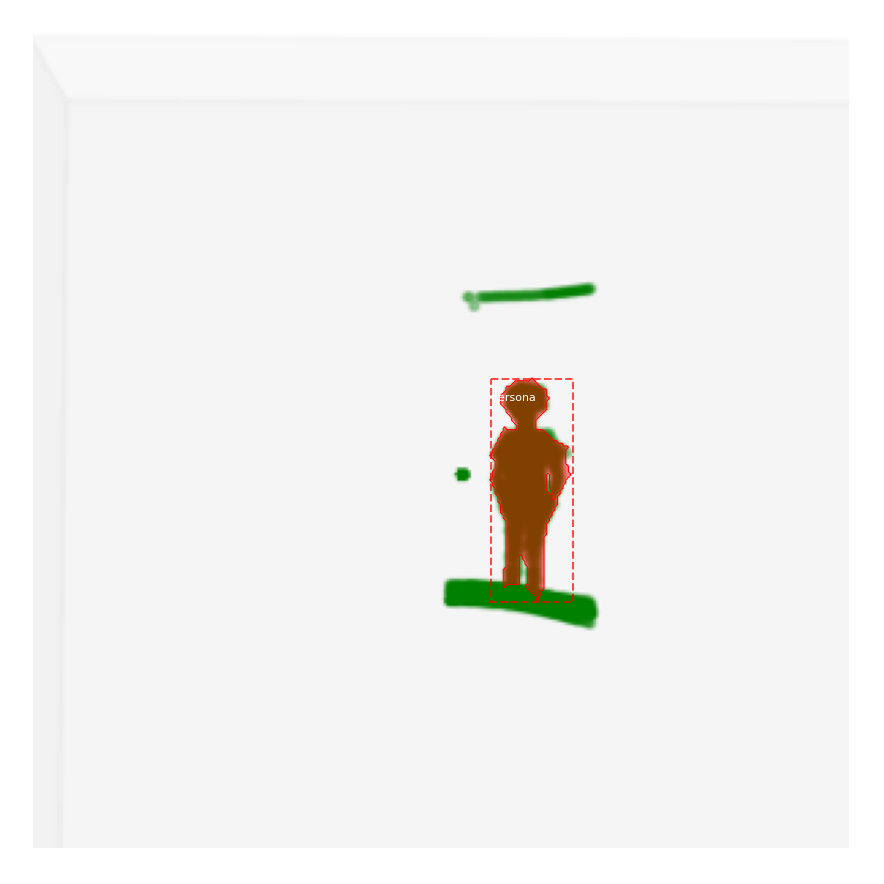

In [14]:
from mrcnn.model import log
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [15]:
###PYTORCH CON U-NET 
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset, random_split
#
import PIL
from PIL import Image
#
!pip install jupyterthemes
from jupyterthemes import jtplot
jtplot.style()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 84.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 7.0 MB/s eta 0:00:00


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [17]:
PATH = '/content/semanticSegmentation/dataset/persona/'
TRAIN_PATH = '/content/semanticSegmentation/dataset/persona/train2/'
TRAIN_MASKS_PATH = '/content/semanticSegmentation/dataset/persona/segmentadas/'
TEST_PATH = '/content/semanticSegmentation/dataset/persona/val2/'
TEST_MASK_PATH = '/content/semanticSegmentation/dataset/persona/valS/'

In [18]:
# creating our own Dataset
class Car_Dataset(Dataset):
    def __init__(self, data, masks=None, img_transforms=None, mask_transforms=None):
        '''
        data - train data path
        masks - train masks path
        '''
        self.train_data = data
        self.train_masks = masks
        
        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms
        
        self.images = sorted(os.listdir(self.train_data))
        self.masks = sorted(os.listdir(self.train_masks))
        
    def __len__(self):
        if self.train_masks is not None:
            assert len(self.images)==len(self.masks), 'not the same number of images and masks'
        return len(self.images)
        
    def __getitem__(self, idx):
        image_name = os.path.join(self.train_data, self.images[idx])
        img = Image.open(image_name)
        trans = T.ToTensor()
        if self.img_transforms is not None:
            img = self.img_transforms(img)
        else:
            img =trans(img)
            img = torch.narrow(img, 1, 0, 3)
        
        if self.train_masks is not None:
            mask_name = os.path.join(self.train_masks, self.masks[idx])
            mask = Image.open(mask_name)
            if self.mask_transforms is not None:
                mask = self.mask_transforms(mask)
            else:
                mask = trans(mask)
            
            mask_max = mask.max().item()
            mask /= mask_max
        else:
            
            return img
        
        return img, mask 

In [19]:
transform_data = T.Compose([
                T.Resize([224, 224]),
                T.ToTensor()] )

In [56]:
full_dataset = Car_Dataset(TRAIN_PATH,
                           TRAIN_MASKS_PATH,
                           img_transforms=transform_data,
                           mask_transforms=transform_data)

In [57]:
BATCH_SIZE = 32
TRAIN_SIZE = int(len(full_dataset)*0.8)
VAL_SIZE = len(full_dataset) - TRAIN_SIZE

print(TRAIN_SIZE, VAL_SIZE)

41 11


In [58]:
train_dataset, val_dataset = random_split(full_dataset, [TRAIN_SIZE, VAL_SIZE])
print(len(train_dataset), len(val_dataset))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
for batch_idx, (inputs, targets) in enumerate(train_loader):
    print(f'Batch {batch_idx}: inputs={inputs.shape}, targets={targets.shape}')
#train_loader[0] = torch.narrow(train_loader[0], 1, 0, 3)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

41 11
Batch 0: inputs=torch.Size([32, 4, 224, 224]), targets=torch.Size([32, 1, 224, 224])
Batch 1: inputs=torch.Size([9, 4, 224, 224]), targets=torch.Size([9, 1, 224, 224])


In [59]:

imgs, masks = next(iter(train_loader))
print(imgs.shape, masks.shape)
#imgs = torch.narrow(imgs, 1, 0, 3)
#print(imgs.shape)
for i, (x, y) in enumerate(train_loader):
    x = torch.narrow(x, 1, 0, 3)
    print(i, x.shape, y.shape)
    if i==9: break

torch.Size([32, 4, 224, 224]) torch.Size([32, 1, 224, 224])
0 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
1 torch.Size([9, 3, 224, 224]) torch.Size([9, 1, 224, 224])


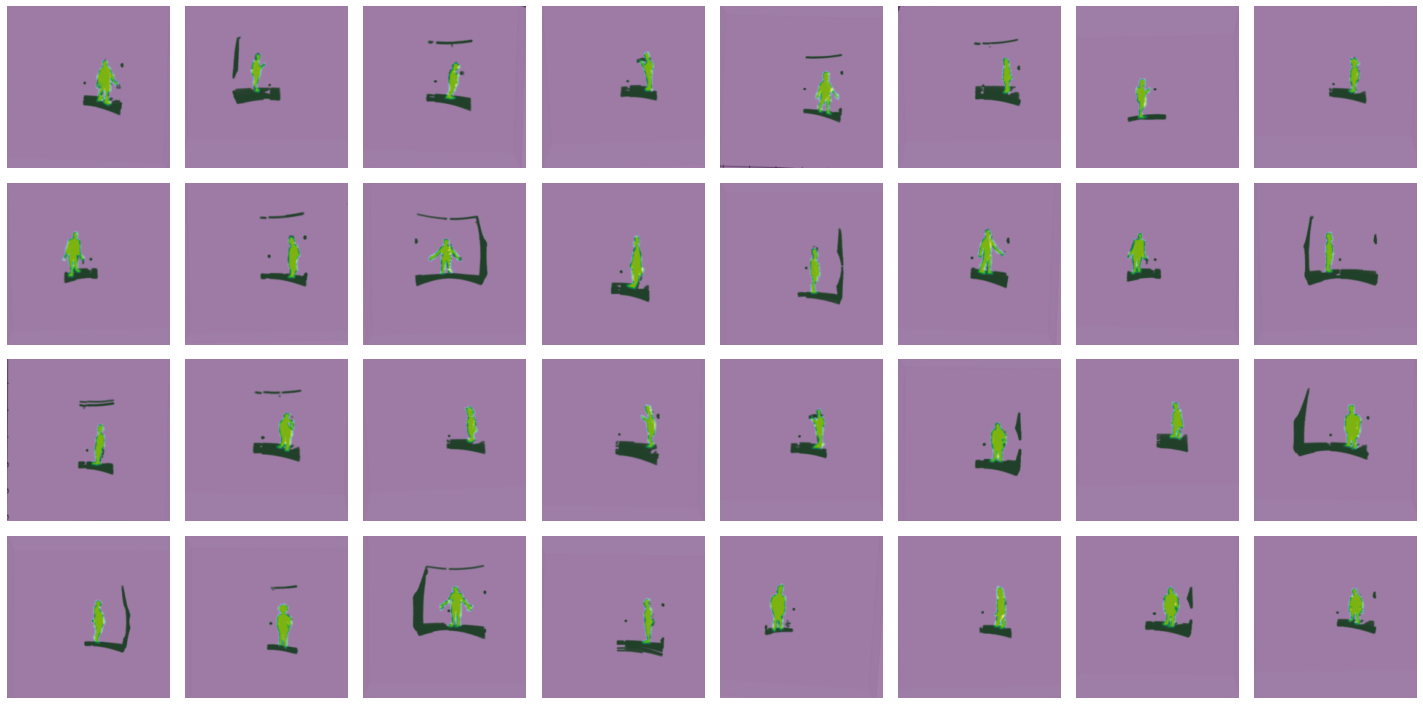

In [60]:
imgs, masks = next(iter(train_loader))
def plot_mini_batch(imgs, masks):
    plt.figure(figsize=(20,10))
    for i in range(BATCH_SIZE):
        plt.subplot(4, 8, i+1)
        img=imgs[i,...].permute(1,2,0).numpy()
        mask = masks[i, ...].permute(1,2,0).numpy()
        plt.imshow(img)
        plt.imshow(mask, alpha=0.5)
        
        plt.axis('Off')
    plt.tight_layout()
    plt.show()

plot_mini_batch(imgs, masks)

In [61]:
def accuracy(model, loader):
    correct = 0
    intersection = 0
    denom = 0
    union = 0
    total = 0
    cost = 0.
    model = model.to(device=device)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype = torch.float32)
            x = torch.narrow(x, 1, 0, 3)
            y = y.to(device=device, dtype = torch.long).squeeze(1)
            scores = model(x)
            cost += (F.cross_entropy(scores, y)).item()
            # standard accuracy not optimal
            preds = torch.argmax(scores, dim=1)
            correct += (preds == y).sum()
            total += torch.numel(preds)
            #dice coefficient
            intersection += (preds*y).sum()
            denom += (preds + y).sum()
            dice = 2*intersection/(denom + 1e-8)
            #intersection over union
            union += (preds + y - preds*y).sum()
            iou = (intersection)/(union + 1e-8)
            
        return cost/len(loader), float(correct)/total, dice, iou

In [62]:
len(train_loader)

2

In [63]:
def find_lr(model, optimiser, start_val = 1e-6, end_val = 1, beta = 0.99, loader = train_loader):
    n = len(loader) - 1
    factor = (end_val / start_val)**(1/n)
    lr = start_val
    optimiser.param_groups[0]['lr'] = lr #this allows you to update the learning rate
    avg_loss, loss, acc = 0., 0., 0.
    lowest_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    accuracies = []
    model = model.to(device=device)
    for i, (x, y) in enumerate(loader, start=1):
        x = x.to(device = device, dtype = torch.float32)
        x = torch.narrow(x, 1, 0, 3)
        y = y.to(device = device, dtype = torch.long).squeeze(1)
        optimiser.zero_grad()
        scores = model(x)
        cost = F.cross_entropy(input=scores, target=y)
        loss = beta*loss + (1-beta)*cost.item()
        #bias correction
        avg_loss = loss/(1 - beta**i)
        
        preds = torch.argmax(scores, dim=1)
        acc_ = (preds == y).sum()/torch.numel(scores)
#         acc = beta*acc + (1-beta)*acc_.item()
#         avg_acc = acc/(1 - beta**i)
        #if loss is massive stop
        if i > 1 and avg_loss > 4 * lowest_loss:
            print(f'from here{i, cost.item()}')
            return log_lrs, losses, accuracies
        if avg_loss < lowest_loss or i == 1:
            lowest_loss = avg_loss

        accuracies.append(acc_.item())
#         accuracies.append(avg_acc)
        losses.append(avg_loss)
        log_lrs.append(lr)
        #step
        cost.backward()
        optimiser.step()
        #update lr
        print(f'cost:{cost.item():.4f}, lr: {lr:.4f}, acc: {acc_.item():.4f}')
        lr *= factor
        optimiser.param_groups[0]['lr'] = lr
        
    return log_lrs, losses, accuracies

In [64]:
def evaluate(model, loader):
    model.eval()
    model.to(device=device)
    with torch.no_grad():
        true_positives = 0
        false_positives = 0
        false_negatives = 0
        total = 0
        cost = 0
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float32)
            x = torch.narrow(x, 1, 0, 3)
            y = y.to(device=device, dtype=torch.long).squeeze(1)
            scores = model(x)
            cost += (F.cross_entropy(scores, y)).item()
            preds = torch.argmax(scores, dim=1)
            true_positives += ((preds == 1) & (y == 1)).sum().item()
            false_positives += ((preds == 1) & (y == 0)).sum().item()
            false_negatives += ((preds == 0) & (y == 1)).sum().item()
            total += torch.numel(preds)
        accuracy = true_positives / total
        recall = true_positives / (true_positives + false_negatives)
        precision = true_positives / (true_positives + false_positives)
        if (precision + recall) ==0:
            f1_score = 0
        else:
            f1_score = 2 * (precision * recall) / (precision + recall)
        true_negatives = total - true_positives - false_positives - false_negatives
        confusion_matrix = [[true_positives, false_positives], [false_negatives, true_negatives]]
        print("Confusion Matrix:")
        print(confusion_matrix)
        return cost / len(loader), accuracy, recall, precision, f1_score, confusion_matrix

In [74]:
def train(model, optimiser, scheduler = None, epochs = 5000, store_every = 25):
    model = model.to(device=device)
    for epoch in range(epochs):
        train_correct_num = 0
        train_total = 0
        train_cost_acum = 0.
        for mb, (x, y) in enumerate(train_loader, start=1):
            model.train()
            x = x.to(device=device, dtype=torch.float32)
            x = torch.narrow(x, 1, 0, 3)
            y = y.to(device=device, dtype=torch.long).squeeze(1)
            scores = model(x)
            cost = F.cross_entropy(input=scores, target=y)
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()
            
            if scheduler: 
                scheduler.step()
                
            train_predictions = torch.argmax(scores, dim=1)
            train_correct_num += (train_predictions == y).sum()
            train_total += torch.numel(train_predictions)
            train_cost_acum += cost.item()
            if mb%store_every == 0:
                val_cost, val_acc, dice, iou = accuracy(model, val_loader)
                train_acc = float(train_correct_num)/train_total
                train_cost_every = float(train_cost_acum)/mb
                loss, accuracy2, recall, precision, f1_score, confusion_matrix = evaluate(model, val_loader)
                print(f'epoch: {epoch}, mb: {mb}, train cost: {train_cost_every:.4f}, val cost: {val_cost:.4f},'
                      f'train acc: {train_acc:.4f}, val acc: {val_acc:.4f},'
                      f'dice: {dice}, iou: {iou}')
            else:
                val_cost, val_acc, dice, iou = accuracy(model, val_loader)
                train_acc = float(train_correct_num)/train_total
                train_cost_every = float(train_cost_acum)/mb
                print(f'epoch: {epoch}, mb: {mb}, train cost: {train_cost_every:.4f}, val cost: {val_cost:.4f},'
                      f'train acc: {train_acc:.4f}, val acc: {val_acc:.4f},'
                      f'dice: {dice}, iou: {iou}')              

            
                    # Save data
                    #train_acc_history.append(train_acc)
                    #train_cost_history.append(train_cost_every)
        #train_acc = float(train_correct_num)/train_total
        #train_cost_every = float(train_cost_acum)/len(train_loader)
        # return train_acc_history ... etc    

In [75]:
class Conv_3_k(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.conv1 = nn.Conv2d(channels_in, channels_out, kernel_size=3, stride=1, padding=1)
    def forward(self, x):
        return self.conv1(x)

In [76]:
class Double_Conv(nn.Module):
    '''
    Double convolution block for U-Net
    '''
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.double_conv = nn.Sequential(
                           Conv_3_k(channels_in, channels_out),
                           nn.BatchNorm2d(channels_out),
                           nn.ReLU(),
            
                           Conv_3_k(channels_out, channels_out),
                           nn.BatchNorm2d(channels_out),
                           nn.ReLU(),
                            )
    def forward(self, x):
        return self.double_conv(x)
    
class Down_Conv(nn.Module):
    '''
    Down convolution part
    '''
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.encoder = nn.Sequential(
                        nn.MaxPool2d(2,2),
                        Double_Conv(channels_in, channels_out)
                        )
    def forward(self, x):
        return self.encoder(x)
    
class Up_Conv(nn.Module):
    '''
    Up convolution part
    '''
    def __init__(self,channels_in, channels_out):
        super().__init__()
        self.upsample_layer = nn.Sequential(
                        nn.Upsample(scale_factor=2, mode='bicubic'),
                        nn.Conv2d(channels_in, channels_in//2, kernel_size=1, stride=1)
                        )
        self.decoder = Double_Conv(channels_in, channels_out)
    
    def forward(self, x1, x2):
        '''
        x1 - upsampled volume
        x2 - volume from down sample to concatenate
        '''
        x1 = self.upsample_layer(x1)
        x = torch.cat([x2, x1],dim=1)
        return self.decoder(x)
    
class UNET(nn.Module):
    '''
    UNET model
    '''
    def __init__(self, channels_in, channels, num_classes):
        super().__init__()
        self.first_conv = Double_Conv(channels_in, channels) #64, 224, 224
        self.down_conv1 = Down_Conv(channels, 2*channels) # 128, 112, 112
        self.down_conv2 = Down_Conv(2*channels, 4*channels) # 256, 56, 56
        self.down_conv3 = Down_Conv(4*channels, 8*channels) # 512, 28, 28
        
        self.middle_conv = Down_Conv(8*channels, 16*channels) # 1024, 14, 14 
        
        self.up_conv1 = Up_Conv(16*channels, 8*channels)
        self.up_conv2 = Up_Conv(8*channels, 4*channels)
        self.up_conv3 = Up_Conv(4*channels, 2*channels)
        self.up_conv4 = Up_Conv(2*channels, channels)
        
        self.last_conv = nn.Conv2d(channels, num_classes, kernel_size=1, stride=1)
        
    def forward(self, x):
        x1 = self.first_conv(x)
        x2 = self.down_conv1(x1)
        x3 = self.down_conv2(x2)
        x4 = self.down_conv3(x3)
        
        x5 = self.middle_conv(x4)
        
        u1 = self.up_conv1(x5, x4)
        u2 = self.up_conv2(u1, x3)
        u3 = self.up_conv3(u2, x2)
        u4 = self.up_conv4(u3, x1)
        
        return self.last_conv(u4)
        

In [ ]:
def test():
    x = torch.randn((32, 3, 224, 224))
    model = UNET(3, 64, 2)
    return model(x)

preds = test()

print(preds.shape)

KeyboardInterrupt: ignored

In [77]:
# define the model and look for learning rate
torch.manual_seed(42)
model = UNET(3, 4, 2)
optimiser_unet = torch.optim.SGD(model.parameters(),
                                 lr=0.01, momentum=0.95,
                                 weight_decay=1e-4)

lg_lr, losses, accuracies = find_lr(model, optimiser_unet, start_val=1e-6, end_val=10)

cost:0.8981, lr: 0.0000, acc: 0.0657
cost:0.9006, lr: 10.0000, acc: 0.0635


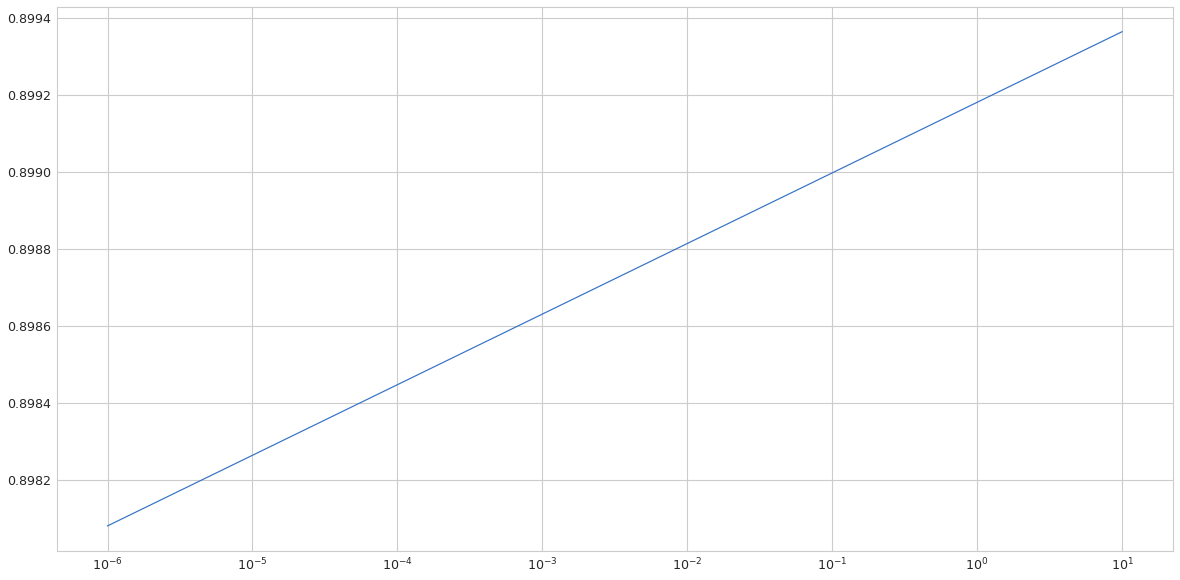

In [78]:
# plot loss vs learning rate
f1, ax1 = plt.subplots(figsize=(20,10))
ax1.plot(lg_lr, losses)
ax1.set_xscale('log')
plt.show()

In [80]:
# define the model and train with scheduler
torch.manual_seed(42)
model = UNET(3, 4, 2)
epochs = 500
optimiser_unet = torch.optim.SGD(model.parameters(),
                                 lr=0.01, momentum=0.95,
                                 weight_decay=1e1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser_unet, 
                                                max_lr = 1e-5,
                                                steps_per_epoch=len(train_loader),
                                                epochs=epochs, pct_start=0.43, div_factor=10, final_div_factor=1000,
                                                three_phase=True)

In [81]:
train(model, optimiser_unet, scheduler, epochs)
loss, accuracy2, recall, precision, f1_score, confusion_matrix = evaluate(model, val_loader)
print("Loss: {:.4f}".format(loss))
print("Accuracy: {:.4f}".format(accuracy2))
print("Recall: {:.4f}".format(recall))
print("Precision: {:.4f}".format(precision))
print("F1 Score: {:.4f}".format(f1_score))
#print("Confusion Matrix: {:.4f}".format(confusion_matrix))  

epoch: 0, mb: 1, train cost: 0.8981, val cost: 0.8970,train acc: 0.1314, val acc: 0.1371,dice: 0.008589104749262333, iou: 0.004313075449317694
epoch: 0, mb: 2, train cost: 0.8994, val cost: 0.8970,train acc: 0.1305, val acc: 0.1372,dice: 0.008593536913394928, iou: 0.0043153101578354836
epoch: 1, mb: 1, train cost: 0.8994, val cost: 0.8970,train acc: 0.1287, val acc: 0.1372,dice: 0.008593590930104256, iou: 0.004315337631851435
epoch: 1, mb: 2, train cost: 0.8980, val cost: 0.8970,train acc: 0.1305, val acc: 0.1372,dice: 0.008590196259319782, iou: 0.004313625395298004
epoch: 2, mb: 1, train cost: 0.8982, val cost: 0.8969,train acc: 0.1315, val acc: 0.1373,dice: 0.008598989807069302, iou: 0.004318060353398323
epoch: 2, mb: 2, train cost: 0.8988, val cost: 0.8969,train acc: 0.1304, val acc: 0.1374,dice: 0.008604174479842186, iou: 0.004320675041526556
epoch: 3, mb: 1, train cost: 0.8986, val cost: 0.8968,train acc: 0.1298, val acc: 0.1374,dice: 0.008600493893027306, iou: 0.00431881891563534

Confusion Matrix:
[[2171, 475397], [49, 74319]]


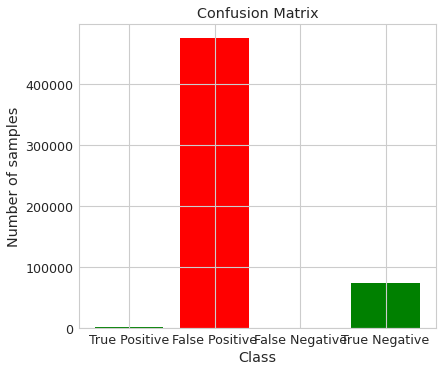

In [82]:

print("Confusion Matrix:")
print(confusion_matrix)
tp, fp = confusion_matrix[0]
fn, tn = confusion_matrix[1]

# Crear una lista con los nombres de las clases
class_names = ["True Positive", "False Positive", "False Negative", "True Negative"]

# Crear una figura y un eje para el gráfico de barras
fig, ax = plt.subplots()

# Crear el gráfico de barras
ax.bar(class_names, [tp, fp, fn, tn], color=["green", "red", "red", "green"])

# Configurar las etiquetas de los ejes y el título del gráfico
ax.set_xlabel("Class")
ax.set_ylabel("Number of samples")
ax.set_title("Confusion Matrix")

# Mostrar el gráfico
plt.show()


[[2171, 475397], [49, 74319]]


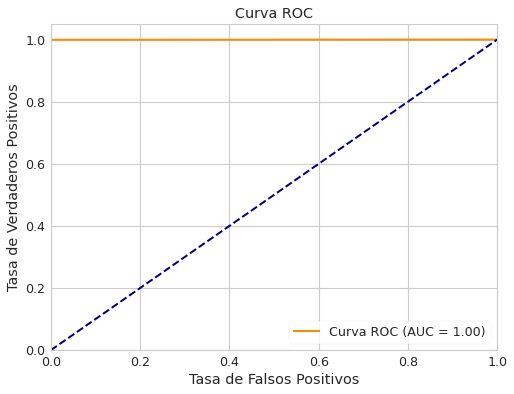

In [83]:
####CURVAS ROC
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

cm = confusion_matrix
print(cm)
cm = np.array(cm)

y_true = np.concatenate([np.zeros(cm[0, 0] + cm[0, 1]), np.ones(cm[1, 0] + cm[1, 1])])
y_scores = np.concatenate([np.zeros(cm[0, 0]), np.ones(cm[1, 0]), np.zeros(cm[0, 1]), np.ones(cm[1, 1])])

# Calcular la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR) para diferentes umbrales de clasificación
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Calcular el área bajo la curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [84]:
#####CURVA LIFT
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# Hacer predicciones con un modelo de clasificación binario y obtener las probabilidades de pertenecer a la clase positiva
y_pred_proba = model.predict_proba(X_test)[:,1]

# Ordenar las predicciones por probabilidad de pertenecer a la clase positiva
order = np.argsort(y_pred_proba)[::-1]
y_pred_proba = y_pred_proba[order]
y_true = y_test[order]

# Dividir los datos en grupos de igual tamaño basados en el porcentaje de ejemplos positivos que se seleccionan
n_groups = 10
group_size = len(y_test) // n_groups
groups = [y_true[i*group_size:(i+1)*group_size] for i in range(n_groups)]
group_probs = [y_pred_proba[i*group_size:(i+1)*group_size] for i in range(n_groups)]

# Calcular la tasa de verdaderos positivos y la tasa de falsos positivos para cada grupo
lift_scores = []
for i in range(n_groups):
    tp = sum(groups[i])
    fp = len(group_probs[i]) - tp
    tn = sum(1-groups[i])
    fn = group_size - tp - fp

AttributeError: ignored

torch.Size([11, 224, 224])


IndexError: ignored

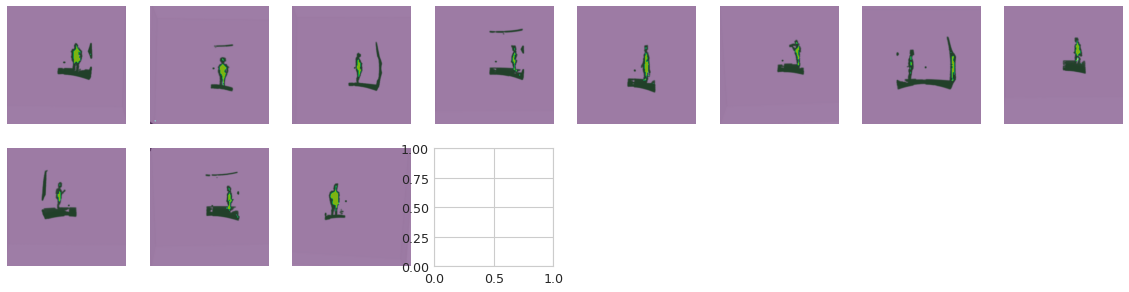

In [ ]:
imgs_val, masks_val = next(iter(val_loader))
imgs_val = imgs_val.to(device, dtype=torch.float32)
imgs_val = torch.narrow(imgs_val, 1, 0, 3)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_val)
    preds = torch.argmax(scores, dim=1).float()

imgs_val = imgs_val.cpu()
preds = preds.cpu()
print(preds.shape)
plot_mini_batch(imgs_val, preds.unsqueeze(1))

In [ ]:
test_set = Car_Dataset(TEST_PATH, img_transforms=transform_data)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
imgs_test = next(iter(test_loader))
imgs_test = imgs_test.to(device, dtype=torch.float32)
imgs_test = torch.narrow(imgs_val, 1, 0, 3)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_test)
    preds = torch.argmax(scores, dim=1).float()

imgs_test = imgs_test.cpu()
preds = preds.cpu()
print(preds.shape)
plot_mini_batch(imgs_test, preds.unsqueeze(1))

RuntimeError: ignored